In [330]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, RobustScaler

# Detecting market regimes

In [331]:
df = pd.read_csv('data/data_preprocessed.csv', index_col=0, parse_dates=True)
log_returns = np.log(df / df.shift(1)).dropna()

In [332]:
# Base features
features = pd.DataFrame(index=log_returns.index)
features['mean_return']   = log_returns.mean(axis=1)
features['volatility']    = log_returns.std(axis=1)
#features['median_return'] = log_returns.median(axis=1)
#features['iqr']           = (log_returns.quantile(0.75, axis=1) - log_returns.quantile(0.25, axis=1))
#features['skewness']      = log_returns.skew(axis=1)
#features['kurtosis']      = log_returns.kurtosis(axis=1)
features['up_frac']       = (log_returns > 0).mean(axis=1)

# Correct drawdown calculation
rolling_peak = df.cummax()               # highest price-to-date
drawdown     = df.div(rolling_peak) - 1  # percent below peak

features['max_drawdown']  = drawdown.min(axis=1)        # worst drop across assets

# Add 1‐ and 2‐day lags without dropping rows
#lags = [1, 2]
#cols_to_lag = ['mean_return', 'volatility', 'max_drawdown']
#for lag in lags:
#    for col in cols_to_lag:
#        features[f'{col}_lag{lag}'] = features[col].shift(lag)

# Fill NaNs from the shifts to keep same row count
#features.bfill(inplace=True)
#features.ffill(inplace=True)

In [333]:
features

,mean_return,volatility,up_frac,max_drawdown
timestamp,,,,
2017-03-08,-0.012348,0.025446,0.248521,-0.109702
2017-03-09,-0.004321,0.013187,0.331361,-0.150350
2017-03-14,0.001178,0.019119,0.550296,-0.187583
2017-03-20,0.011657,0.030887,0.810651,-0.239511
2017-03-21,-0.007886,0.023945,0.325444,-0.200125
...,...,...,...,...
2023-01-05,-0.003569,0.029990,0.343195,-0.999222
2023-01-06,0.014127,0.021099,0.881657,-0.999282
2023-01-09,0.013946,0.032685,0.822485,-0.999383


In [334]:
# Cluster days into 3 regimes

kmeans = KMeans(n_clusters=3, random_state=45)
labels = kmeans.fit_predict(features)

# Map cluster IDs → regime names (Bear < Risky < Bull by mean_return)
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=features.columns
)

ordered_ids = centers['mean_return'].sort_values().index.tolist()

regime_map = {
    ordered_ids[0]: 'Bear',    # lowest mean_return
    ordered_ids[1]: 'Risky',   # middle
    ordered_ids[2]: 'Bull'     # highest mean_return
}

regimes = pd.Series(labels, index=features.index).map(regime_map)
regimes.to_csv('data/regimes.csv')

print(regimes.value_counts())


Bull     721
Bear     609
Risky    116
Name: count, dtype: int64


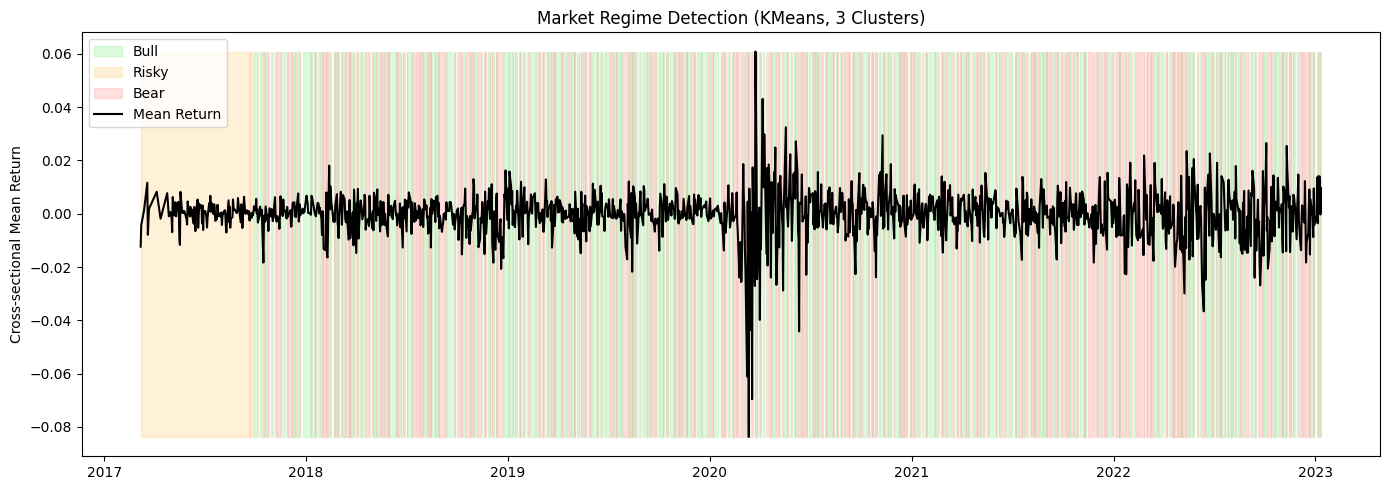

In [335]:
# Plot regimes over the mean_return series
plt.figure(figsize=(14, 5))
ymin, ymax = features['mean_return'].min(), features['mean_return'].max()

for regime, color in zip(['Bull', 'Risky', 'Bear'], ['#90ee90', '#ffd27f', '#ff9999']):
    mask = (regimes == regime)
    plt.fill_between(
        features.index, ymin, ymax,
        where=mask, color=color, alpha=0.3, label=regime
    )

plt.plot(features.index, features['mean_return'], color='k', lw=1.5, label='Mean Return')
plt.title('Market Regime Detection (KMeans, 3 Clusters)')
plt.ylabel('Cross-sectional Mean Return')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [336]:
# Silhouette score
sil_score = silhouette_score(features, labels)
print(f"Silhouette score: {sil_score:.3f}")

Silhouette score: 0.519


We tried scaling the features before scaling but it hurt the silhouette score so bad. We decided to skip it since the features are somewhat in a comparable scale.

Also, we managed to have silhouette score of 0.72 by adding features (kurtosis and skewness), but in this case it was not really interesting for the data augmentation part as we had most data points in the risky regime.

# Data augmentation

In [337]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [338]:
augmented_df

,CSCO,SPXU,UAL,SPLG,MRO,TIP,CS,USMV,CTRA,ESGE,...,PBR.A,SLV,LABU,M,CRM,PDBC,EELV,SPTL,KWEB,PPL
2017-03-02,28.545556,321.323333,73.674300,100.609091,15.065926,94.927407,13.568519,43.123704,19.161111,25.923333,...,6.500037,17.009685,53.035185,25.068889,82.684533,9.137407,17.729167,60.312609,35.803077,27.345185
2017-03-08,28.293704,328.484444,73.139522,100.026667,14.346667,94.505926,13.303704,42.751481,19.515926,26.026667,...,6.306259,16.356359,51.317778,23.867778,83.556793,8.997462,17.838947,59.703182,36.569259,27.017037
2017-03-09,28.253333,330.135556,73.215370,99.701250,14.476296,94.270000,13.349259,42.734074,19.181481,25.734000,...,6.074074,16.148278,51.398519,23.865185,83.286130,8.814885,17.700000,59.446667,36.133333,27.079630
2017-03-14,28.298462,329.938148,67.317304,99.686000,14.130370,94.154783,13.306522,42.835652,19.054348,26.225000,...,5.878333,16.039242,51.087500,23.675000,83.148333,8.677522,17.937143,59.466250,37.020000,27.293478
2017-03-20,28.488000,325.258462,67.514200,100.210000,14.256400,95.149615,13.376087,43.167826,19.148333,27.222500,...,5.890652,16.498544,51.247826,22.660400,83.154200,8.800478,18.636364,60.388125,38.119565,27.602500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-10-05,55.917227,3.383653,72.283228,29.674264,1.341329,113.830960,0.451100,101.780131,17.475320,24.775145,...,4.833597,35.242403,1.865119,89.956734,298.481566,6.296312,28.953498,24.518152,22.974145,64.433726
2028-10-06,56.842470,3.304220,75.067997,29.883221,1.370067,113.353939,0.461206,101.982168,17.290400,24.763605,...,4.896521,34.997193,1.933765,91.254392,303.838079,6.306549,28.857911,24.301182,23.287890,64.299454
2028-10-09,57.497986,3.210982,75.092399,30.163362,1.392069,113.483016,0.462190,102.442011,17.537089,25.098944,...,5.220746,34.817651,1.890014,90.400004,314.280828,6.309797,29.118781,24.346850,23.455903,64.229778
2028-10-10,57.510073,3.205185,73.596598,30.171127,1.434688,113.796613,0.459100,102.678969,17.364361,25.245776,...,5.335018,35.349923,1.927872,91.366541,313.330646,6.397258,29.231226,24.392282,23.601315,64.449255


Bear Ep 100/1000 loss=47.1855
Bear Ep 200/1000 loss=33.6838
Bear Ep 300/1000 loss=29.2460
Bear Ep 400/1000 loss=26.1096
Bear Ep 500/1000 loss=24.6802
Bear Ep 600/1000 loss=24.2488
Bear Ep 700/1000 loss=22.6772
Bear Ep 800/1000 loss=21.7073
Bear Ep 900/1000 loss=21.5761
Bear Ep 1000/1000 loss=22.0897


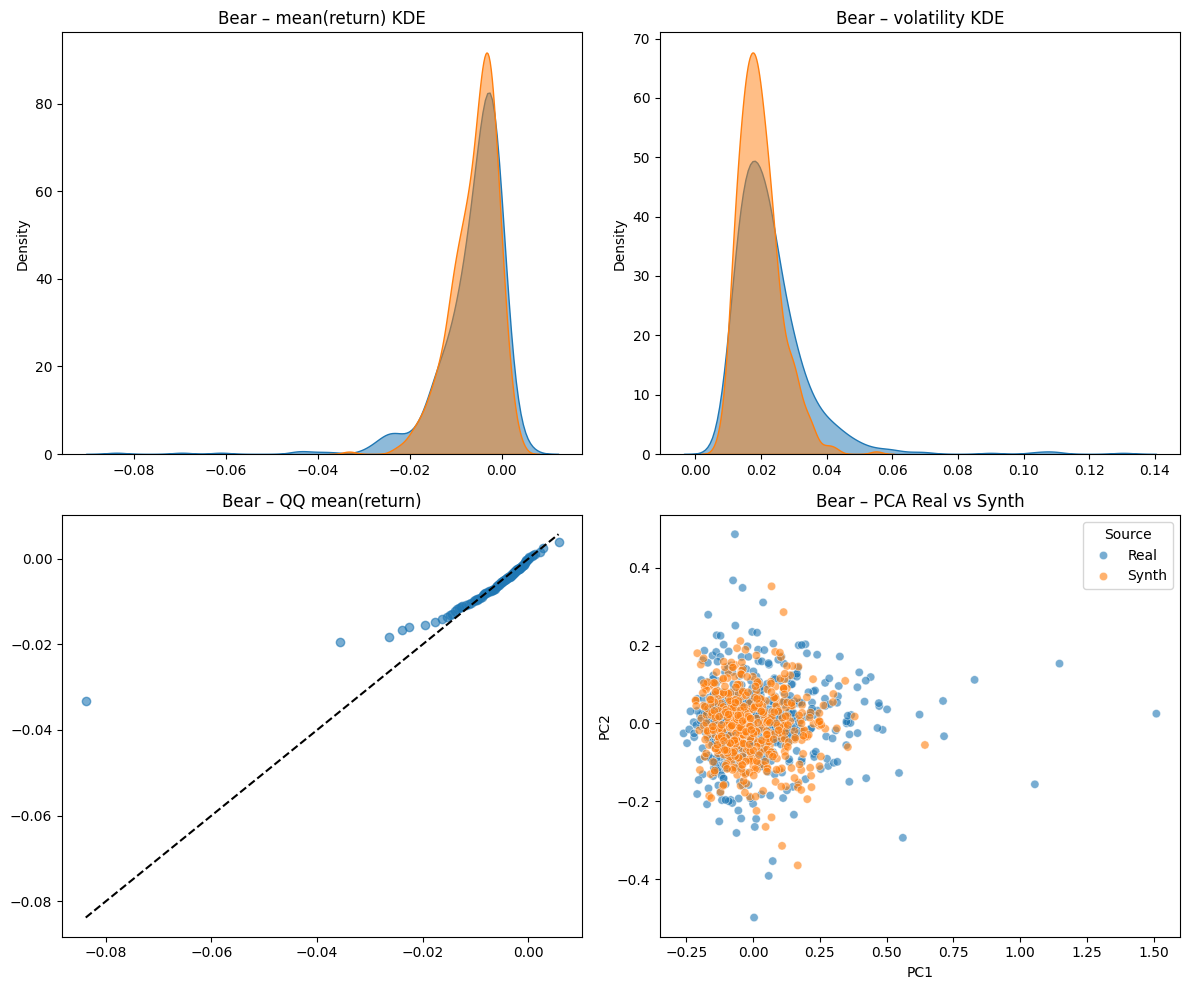

Risky Ep 100/1000 loss=20.2273
Risky Ep 200/1000 loss=11.9961
Risky Ep 300/1000 loss=8.8936
Risky Ep 400/1000 loss=7.7006
Risky Ep 500/1000 loss=6.8670
Risky Ep 600/1000 loss=6.3249
Risky Ep 700/1000 loss=6.0425
Risky Ep 800/1000 loss=5.8942
Risky Ep 900/1000 loss=5.7664
Risky Ep 1000/1000 loss=5.6366


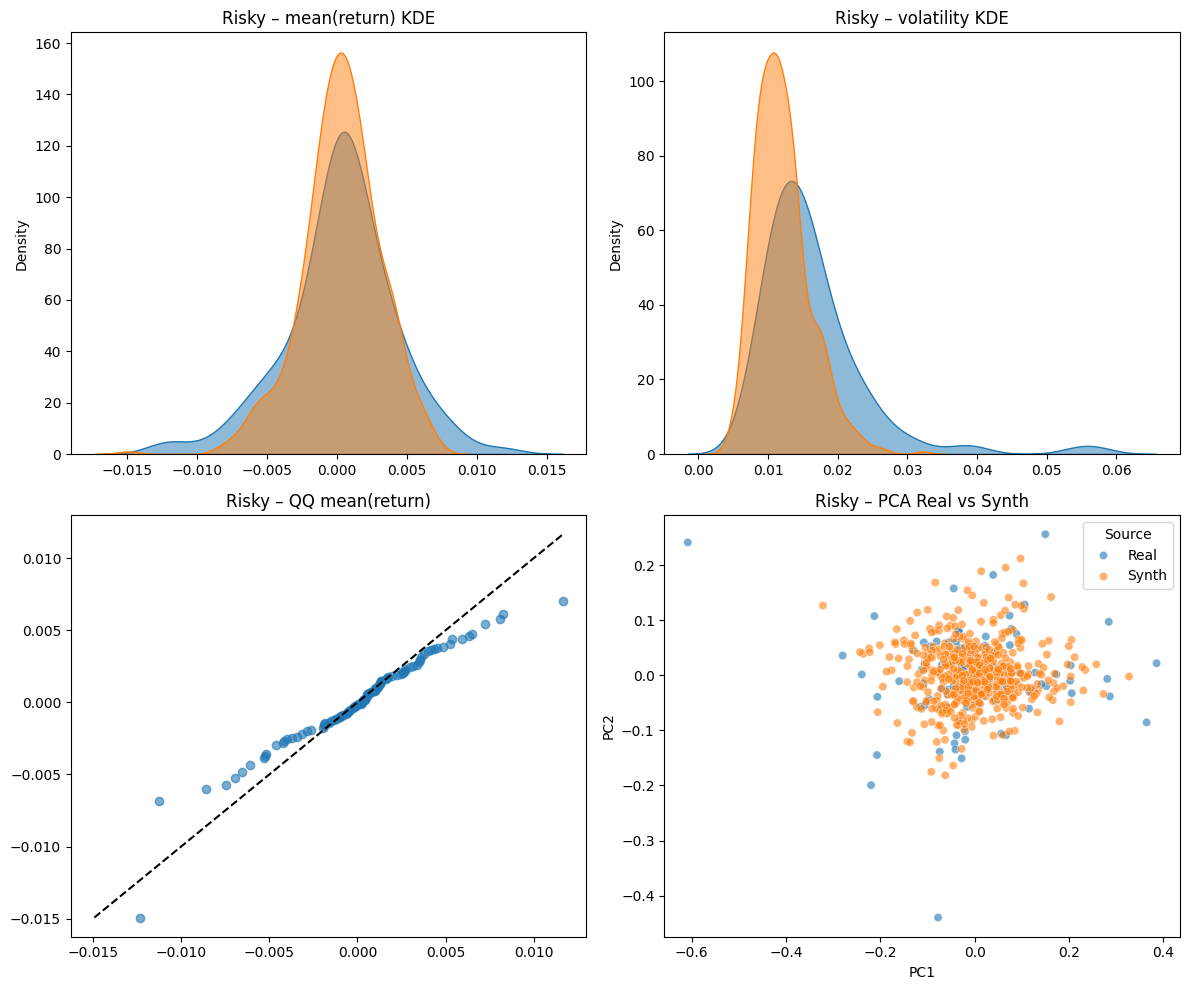

Bull Ep 100/1000 loss=35.7159
Bull Ep 200/1000 loss=28.9238
Bull Ep 300/1000 loss=25.6796
Bull Ep 400/1000 loss=24.1195
Bull Ep 500/1000 loss=23.2540
Bull Ep 600/1000 loss=22.6466
Bull Ep 700/1000 loss=21.7316
Bull Ep 800/1000 loss=21.1084
Bull Ep 900/1000 loss=20.7775
Bull Ep 1000/1000 loss=20.2521


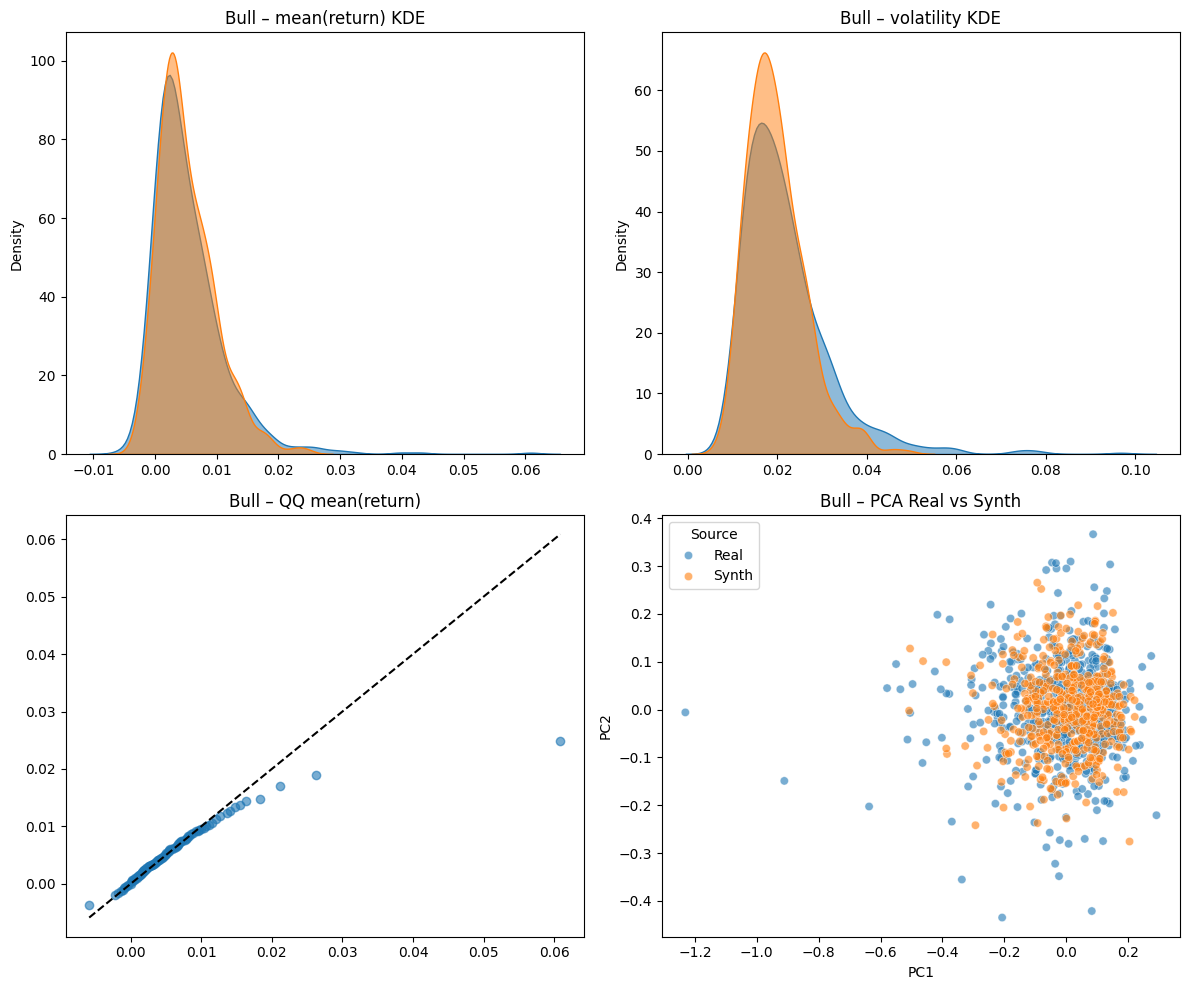

Augmented price panel shape: (2947, 169)


In [339]:
# Load prices & regimes
df = pd.read_csv('data/data_preprocessed.csv', index_col=0, parse_dates=True)
logr = np.log(df / df.shift(1)).dropna()

# Scale log-returns for VAE input
scaler = StandardScaler()
returns_scaled = pd.DataFrame(
    scaler.fit_transform(logr),
    index=logr.index,
    columns=logr.columns
)

class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=10, beta=0.2):
        super().__init__()
        self.beta = beta
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu    = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar= nn.Linear(hidden_dim, latent_dim)
        self.dec1 = nn.Linear(latent_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.out  = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = F.relu(self.enc1(x)); h = F.relu(self.enc2(h))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp(); eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu(self.dec1(z)); h = F.relu(self.dec2(h))
        return self.out(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon, x, mu, logvar, beta):
    re  = F.mse_loss(recon, x, reduction='sum')
    kl  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return re + beta * kl

# plotting
def assess_visual(real_df, synth_df, regime_name):
    combined = pd.concat([real_df.assign(Source='Real'),
                          synth_df.assign(Source='Synth')])
    coords = PCA(n_components=2).fit_transform(combined[real_df.columns])
    df_pca = pd.DataFrame(coords, columns=['PC1','PC2'])
    df_pca['Source'] = combined['Source'].values

    fig, axes = plt.subplots(2,2, figsize=(12,10))
    sns.kdeplot(real_df.mean(axis=1), ax=axes[0,0], label='Real', fill=True, alpha=0.5)
    sns.kdeplot(synth_df.mean(axis=1), ax=axes[0,0], label='Synth', fill=True, alpha=0.5)
    axes[0,0].set_title(f'{regime_name} – mean(return) KDE')
    sns.kdeplot(real_df.std(axis=1), ax=axes[0,1], label='Real', fill=True, alpha=0.5)
    sns.kdeplot(synth_df.std(axis=1), ax=axes[0,1], label='Synth', fill=True, alpha=0.5)
    axes[0,1].set_title(f'{regime_name} – volatility KDE')

    q = np.linspace(0,1,100)
    rq = np.quantile(real_df.mean(axis=1), q)
    sq = np.quantile(synth_df.mean(axis=1), q)
    axes[1,0].scatter(rq, sq, alpha=0.6)
    mmin, mmax = min(rq.min(), sq.min()), max(rq.max(), sq.max())
    axes[1,0].plot([mmin,mmax],[mmin,mmax],'k--')
    axes[1,0].set_title(f'{regime_name} – QQ mean(return)')
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Source', alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title(f'{regime_name} – PCA Real vs Synth')
    plt.tight_layout(); plt.show()

input_dim = returns_scaled.shape[1]
epochs, batch_size, n_samples = 1000, 32, 500
last_prices = df.iloc[-1]
synth_returns_all = []

for regime in ['Bear', 'Risky', 'Bull']:
    X = returns_scaled[regimes == regime].values
    ds = TensorDataset(torch.from_numpy(X).float())
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model = BetaVAE(input_dim, 128, 10, beta=0.2)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for ep in range(epochs):
        L=0
        for (batch,) in dl:
            opt.zero_grad()
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar, model.beta)
            loss.backward(); opt.step()
            L+=loss.item()
        if (ep+1)%100==0:
            print(f"{regime} Ep {ep+1}/{epochs} loss={L/len(ds):.4f}")

    model.eval()
    with torch.no_grad():
        Z = torch.randn(n_samples, model.fc_mu.out_features)
        synth_scaled = model.decode(Z).numpy()

    synth_returns = pd.DataFrame(
        scaler.inverse_transform(synth_scaled),
        columns=logr.columns
    )
    real_ret = logr[regimes==regime]
    assess_visual(real_ret, synth_returns, regime)

    synth_returns_all.append(synth_returns)

# Concatenate all synthetic return blocks in regime order
all_synth_returns = pd.concat(synth_returns_all, ignore_index=True)

# Create one contiguous synthetic price path
from pandas.tseries.offsets import BDay
dates = pd.bdate_range(df.index.max() + BDay(1), periods=len(all_synth_returns), freq='B')
synth_prices = all_synth_returns.cumsum().apply(np.exp).mul(last_prices, axis=1)
synth_prices.index = dates

# Final augmented price panel
augmented_df = pd.concat([df, synth_prices])
print("Augmented price panel shape:", augmented_df.shape)
augmented_df.to_csv('data/augmented_prices.csv')


NB: We create one synthetic block after the real data block and we preserve: 

- the same order of regimes,
- the same number of points per regime,
- unique business date per row (no overlap),
